In [ ]:
!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation: t

In [ ]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.backend import get_value, ctc_decode
from tensorflow.keras.models import load_model


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(tf.__version__)

2.15.0


# Необходимые функции

In [ ]:
class CERMetric(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the Character Error Rate
    """
    def __init__(self, name='CER_metric', **kwargs):
        super(CERMetric, self).__init__(name=name, **kwargs)
        self.cer_accumulator = self.add_weight(name="total_cer", initializer="zeros")
        self.counter = self.add_weight(name="cer_count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        input_shape = K.shape(y_pred)
        input_length = tf.ones(shape=input_shape[0]) * K.cast(input_shape[1], 'float32')

        decode, log = K.ctc_decode(y_pred, input_length, greedy=True)

        decode = K.ctc_label_dense_to_sparse(decode[0], K.cast(input_length, 'int32'))
        y_true_sparse = K.ctc_label_dense_to_sparse(y_true, K.cast(input_length, 'int32'))
        y_true_sparse = tf.sparse.retain(y_true_sparse, tf.not_equal(y_true_sparse.values, tf.math.reduce_max(y_true_sparse.values)))

        decode = tf.sparse.retain(decode, tf.not_equal(decode.values, -1))
        distance = tf.edit_distance(decode, y_true_sparse, normalize=True)

        self.cer_accumulator.assign_add(tf.reduce_sum(distance))
        self.counter.assign_add(K.cast(len(y_true), 'float32'))

    def result(self):
        return tf.math.divide_no_nan(self.cer_accumulator, self.counter)

    def reset_state(self):
        self.cer_accumulator.assign(0.0)
        self.counter.assign(0.0)


def CTCLoss(y_true, y_pred):
    """
    Compute the training-time loss value
    """
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = K.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
def numToLabel(num, alphabet):
  text = ""
  for ch in num:
    if ch == len(alphabet): # пустой
      break
    else:
      text += alphabet[ch]
  return text

In [ ]:
def decodeText(nums):
  values = get_value(ctc_decode(nums, input_length=np.ones(nums.shape[0])*nums.shape[1],
                                greedy=True)[0][0])
  texts = []
  for i in range(nums.shape[0]):
    value = values[i]
    texts.append(numToLabel(value[value >= 0], alphabet))
  return texts

In [ ]:
def getTextLinesRegionFromImage(image):
  if image is None:
    raise ValueError("Invalid image file.")

  imgHeight, imgWidth, _ = image.shape
  blockSize, constC = 21, 10
  if max(imgHeight, imgWidth) < 1000:
      blockSize = 21
      constC = 20
  elif max(imgHeight, imgWidth) in range(1000, 2500):
      blockSize = 21
      constC = 30
  elif max(imgHeight, imgWidth) > 2500:
      blockSize = 31
      constC = 15

  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  print("Avrg brightness lvl: %.4f" % np.average(gray))
  if np.average(gray) < (255 * 0.5):
      gray = cv2.bitwise_not(gray)
  # blur = cv2.GaussianBlur(gray, (3, 3), 0)
  blur = cv2.bilateralFilter(gray, 5, 75, 75)
  bw = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                             cv2.THRESH_BINARY_INV, blockSize, constC)

  kernelSize = (15, 1)
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize)
  bwClosed = cv2.morphologyEx(bw, cv2.MORPH_GRADIENT, kernel) #MORPH_CLOSE #MORPH_GRADIENT

  contours, _ = cv2.findContours(bwClosed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  filteredContours = [cnt for cnt in contours if (cv2.boundingRect(cnt)[2] / cv2.boundingRect(cnt)[3]) >= 3.0]
  filteredContours = [cnt for cnt in filteredContours if (cv2.boundingRect(cnt)[3]) > (int(imgHeight / 100) + (imgHeight % 100 > 0))]
  sortedContours = sorted(filteredContours, key=lambda contour: cv2.boundingRect(contour)[1])

  padding = 3
  for contour in sortedContours:
      x, y, w, h = cv2.boundingRect(contour)
      x, y, w, h = (x - padding, y - padding, w + padding, h + 2*padding)
      cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
      line_image = image[y:y + h, x:x + w]

  return sortedContours, image

In [ ]:
def recognizeTextLine(orgImage, contour, padding = 4, referenceX = 800, referenceY = 64):
  referenceRatio = referenceX / referenceY
  orgSize_Y, orgSize_X, _ = orgImage.shape

  x, y, w, h = cv2.boundingRect(contour)
  x, y, w, h = (x - padding if x - padding > 0 else 0,
                y - padding if y - padding > 0 else 0,
                w + padding if w + padding < orgSize_X else orgSize_X,
                h + 2*padding if h + 2*padding < orgSize_Y else orgSize_Y)
  tempRatio = w / h

  # Если соотношение строн не совпадает с таковым из обучающей выборки,
  # то изображение будет поделено
  if tempRatio > referenceRatio:
    devideCoef = int(tempRatio / referenceRatio) + 1
  else:
    devideCoef = 1

  startPosition = 0
  tempString = ""
  for i in range(0, devideCoef):
    lineImage = orgImage[y : y + h,
                        x + startPosition : x + int(w / devideCoef) * (i + 1)]
    lineImage = cv2.cvtColor(lineImage, cv2.COLOR_BGR2GRAY)

    if np.average(lineImage) < (255 * 0.5):
      lineImage = cv2.bitwise_not(lineImage)

    # Приведение к размерам из обучающей выборки
    shrinkMultiplayer = min(math.floor(referenceY / lineImage.shape[0] * 100) / 100,
                              math.floor(referenceX / lineImage.shape[1] * 100) / 100)
    lineImage = cv2.resize(lineImage, None,
                          fx = shrinkMultiplayer,
                          fy = shrinkMultiplayer,
                          interpolation=cv2.INTER_AREA)
    tempImage = cv2.copyMakeBorder(lineImage, math.ceil(referenceY/2) - math.ceil(lineImage.shape[0]/2),
                            math.floor(referenceY/2) - math.floor(lineImage.shape[0]/2),
                            math.ceil(referenceX/2) - math.ceil(lineImage.shape[1]/2),
                            math.floor(referenceX/2) - math.floor(lineImage.shape[1]/2),
                            cv2.BORDER_CONSTANT, value=255)

    tempImage = cv2.rotate(tempImage, cv2.ROTATE_90_CLOCKWISE)
    # tempImage = cv2.bilateralFilter(tempImage, 3, 75, 75)
    tempImage = cv2.GaussianBlur(tempImage, (3, 3), 0)

    # # Если нужно использовать адаптивный порог значений цвета
    # blockSize, constC = 21, 10
    # if max(orgSize_Y, orgSize_X) < 1000:
    #     blockSize = 21
    #     constC = 20
    # elif max(orgSize_Y, orgSize_X) in range(1000, 2500):
    #     blockSize = 21
    #     constC = 30
    # elif max(orgSize_Y, orgSize_X) > 2500:
    #     blockSize = 31
    #     constC = 15
    # tempImage = cv2.adaptiveThreshold(tempImage, 255,
    #                                   cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,
    #                                   blockSize, constC).astype('bool')

    tempImage = cv2.threshold(tempImage, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1].astype('bool')
    tempImage = tempImage.reshape((1, referenceX, referenceY, 1))
    predicts = model.predict([tempImage])
    predicts_1 = decodeText(predicts)
    tempString += ''.join(predicts_1)
    startPosition = int(w / devideCoef) * (i + 1)

  return tempString

# Распознавалка

In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/OCR наброски/CRNN_model.h5', custom_objects={'CTCLoss' : CTCLoss, 'CERMetric': CERMetric})

In [ ]:
filesPath = "/content/drive/MyDrive/Colab Notebooks/OCR наброски"
with open("%s/OCRdata/alphabet.txt" % filesPath, 'r') as file:
    alphabet = file.read().replace('\n', '')

In [ ]:
fileName = "/content/02.png"
image = cv2.imread("%s" % fileName)
orgImg = image.copy()
sortedContours, image = getTextLinesRegionFromImage(image)

Avrg brightness lvl: 235.3563


1/1 [==============================] - 0s 320ms/step
Результат распознавания:
--------------------------------------------------------------
6: настройхи
оайл сопоставлениа типов:
222&222&2 [2]
8йзzздзалQQQQдaQsd_
L222Z
222&2222& [2]
айл гопоставления обектов слоям
222&22222 [2]
lS Аппроксимироз-криысорэкхэми в хтвми
l2 эхспорироэ-`b-фУ проймов :~`f-cnr
lS рмоля--б-стм с многослойным мз-риломнэчэси
D эхспортирова-гсомстричсскоспр хтамлснисбэ похрэок
fcgQzu_sxzsggszaasussszz_
O Axiz]
D fofrir-
r l3 Tsclsion
: 2 9м`p-lid
? & b-p
l2 $u/sc-
__Смена,
__3k_

--------------------------------------------------------------


(-0.5, 539.5, 631.5, -0.5)

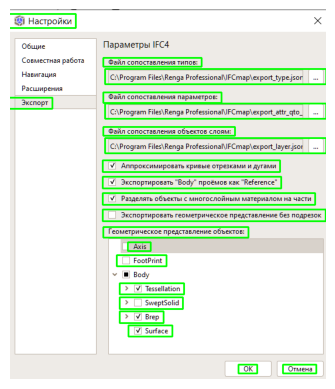

In [ ]:
string = ""
for contour in sortedContours:
  tempString = recognizeTextLine(orgImg, contour, 10)
  if tempString != "":
    string += tempString + "\n"
print("Результат распознавания:\n--------------------------------------------------------------")
print(string)
print("--------------------------------------------------------------")

plt.imshow(image)
plt.axis('off')

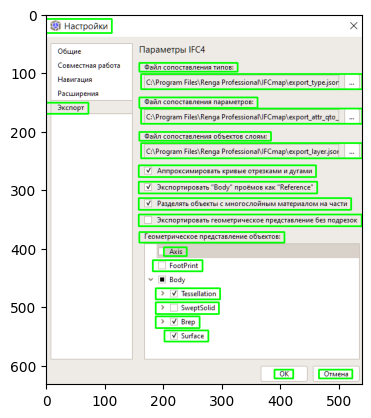

In [ ]:
import matplotlib.image

plt.imshow(image)
matplotlib.image.imsave('/content/out.png', image)

378
1/1 [==============================] - 1s 529ms/step
c:\program rileg\kenga p-ofessiolnaiIrcmap\xpot_ypejzor..


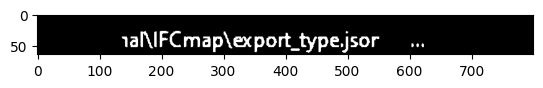

In [ ]:
# Эксперименты по распознаванию текста
padding = 3
referenceRatio = 800 / 64

x, y, w, h = cv2.boundingRect(sortedContours[2])
x, y, w, h = (x - padding, y - padding, w + padding, h + padding)
tempRatio = w / h
print(w)

if tempRatio > referenceRatio:
  devideCoef = int(tempRatio / referenceRatio) + 1
else:
  devideCoef = 1

startPosition = 0
tempString = ""
for i in range(0, devideCoef):
  line_image = orgImg[y:y + h, x + startPosition:x + int(w / devideCoef) * (i + 1)]
  line_image = cv2.cvtColor(line_image, cv2.COLOR_BGR2GRAY)
  if np.average(line_image) < (255 * 0.5):
    line_image = cv2.bitwise_not(line_image)

  shrink_multiplayer = min(math.floor(64 / line_image.shape[0] * 100) / 100,
                             math.floor(800 / line_image.shape[1] * 100) / 100)
  line_image = cv2.resize(line_image, None,
                         fx = shrink_multiplayer,
                         fy = shrink_multiplayer,
                         interpolation=cv2.INTER_AREA)
  tempImage = cv2.copyMakeBorder(line_image, math.ceil(64/2) - math.ceil(line_image.shape[0]/2),
                           math.floor(64/2) - math.floor(line_image.shape[0]/2),
                           math.ceil(800/2) - math.ceil(line_image.shape[1]/2),
                           math.floor(800/2) - math.floor(line_image.shape[1]/2),
                           cv2.BORDER_CONSTANT, value=255)

  # tempImage = cv2.resize(line_image, (800, 64),
  #                        interpolation=cv2.INTER_AREA)
  tempImage = cv2.rotate(tempImage, cv2.ROTATE_90_CLOCKWISE)
  tempImage = cv2.GaussianBlur(tempImage, (3, 3), 0)
  tempImage = cv2.threshold(tempImage, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1].astype('bool')
  plt.imshow(cv2.rotate(
      (tempImage).astype(np.uint8),cv2.ROTATE_90_COUNTERCLOCKWISE), cmap='gray')
  # break
  tempImage = tempImage.reshape((1, 800, 64, 1))
  predicts = model.predict([tempImage])
  predicts_1 = decodeText(predicts)
  tempString += ''.join(predicts_1)
  startPosition = int(w / devideCoef) * (i + 1)
  # break
print(tempString)




# Эксперименты с выделением слов из строки с текстом

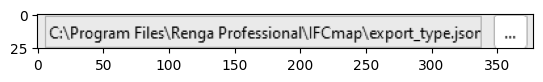

In [ ]:
padding = 3
orgSize_Y, orgSize_X, _ = orgImg.shape
x, y, w, h = cv2.boundingRect(sortedContours[2])
x, y, w, h = (x - padding if x - padding >= 0 else 0,
              y - padding if y - padding >= 0 else 0,
              w + padding if w + padding <= orgSize_X else orgSize_X,
              h + 2*padding if h + 2*padding <= orgSize_Y else orgSize_Y)
line_image = orgImg[y:y + h, x:x + w]
orgSize_Y, orgSize_X, _ = line_image.shape
line_image = cv2.cvtColor(line_image, cv2.COLOR_BGR2GRAY)
# line_image = cv2.copyMakeBorder(line_image, int(h / 3), int(h / 3), int(h / 3), int(h / 3),
#                           cv2.BORDER_CONSTANT, value=int(np.average(line_image[0])))
plt.imshow(line_image, cmap="gray", vmax = 255, vmin = 0)

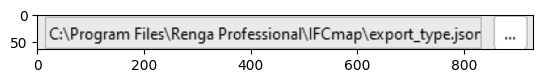

In [ ]:
want_y = 64
shrink_multiplayer = math.floor(want_y / line_image.shape[0] * 100) / 100
line_image = cv2.resize(line_image, None,
                        fx = shrink_multiplayer,
                        fy = shrink_multiplayer,
                        interpolation=cv2.INTER_AREA)

# print(math.ceil(want_y/2),  math.ceil(line_image.shape[0]/2))

# tempImage = cv2.copyMakeBorder(line_image, math.ceil(want_y/2) - math.ceil(line_image.shape[0]/2),
#                           math.floor(want_y/2) - math.floor(line_image.shape[0]/2),
#                           math.ceil(orgSize_X * shrink_multiplayer/2) - math.ceil(line_image.shape[1]/2),
#                           math.floor(orgSize_X * shrink_multiplayer/2) - math.floor(line_image.shape[1]/2),
#                           cv2.BORDER_CONSTANT, value=255)
tempImage = line_image
dtr_img = tempImage.copy()
plt.imshow(tempImage, cmap="gray", vmax = 255, vmin = 0)

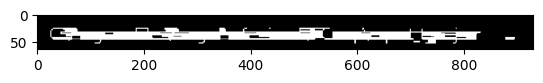

In [ ]:
dtr_img = tempImage.copy()
blur = cv2.bilateralFilter(tempImage, 5, 75, 75)
bw = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                            cv2.THRESH_BINARY_INV, 11, 30)
# bw = cv2.threshold(blur, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)[1]

kernel_size = (15, 1)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
bw_closed = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel) #MORPH_CLOSE #MORPH_GRADIENT
plt.imshow(bw_closed, cmap="gray", vmax = 255, vmin = 0)

contours, _ = cv2.findContours(bw_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

filtered_contours = [cnt for cnt in contours if (cv2.boundingRect(cnt)[2] / cv2.boundingRect(cnt)[3]) >= 3.0]
filtered_contours = [cnt for cnt in filtered_contours
                     if (cv2.boundingRect(cnt)[3]) >
                     (int(cv2.boundingRect(cnt)[3] / 100) + (cv2.boundingRect(cnt)[3] % 100 > 0))]
sortedd = sorted(filtered_contours, key=lambda contour: cv2.boundingRect(contour)[1])

padding = 3
for contour in sortedd:
    x, y, w, h = cv2.boundingRect(contour)
    x, y, w, h = (x - padding, y - padding, w + padding, h + padding)
    cv2.rectangle(dtr_img, (x, y), (x + w, y + h), (0, 255, 0), 2)


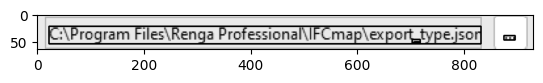

In [ ]:
plt.imshow(dtr_img, cmap="gray", vmax = 255, vmin = 0)

In [ ]:
referenceRatio = 800 / 64



shrink_multiplayer = math.floor(64 / line_image.shape[0] * 100) / 100
line_image = cv2.resize(line_image, None,
                        fx = shrink_multiplayer,
                        fy = shrink_multiplayer,
                        interpolation=cv2.INTER_AREA)
tempImage = cv2.copyMakeBorder(line_image, math.ceil(64/2) - math.ceil(line_image.shape[0]/2),
                          math.floor(64/2) - math.floor(line_image.shape[0]/2),
                          math.ceil(orgSize_X * shrink_multiplayer/2) - math.ceil(line_image.shape[1]/2),
                          math.floor(orgSize_X * shrink_multiplayer/2) - math.floor(line_image.shape[1]/2),
                          cv2.BORDER_CONSTANT, value=255)
tempImage = cv2.rotate(tempImage, cv2.ROTATE_90_CLOCKWISE)
tempImage = cv2.GaussianBlur(tempImage, (3, 3), 0)
tempImage = cv2.threshold(tempImage, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1].astype('bool')
plt.imshow(tempImage)

kernel_size = (15, 1)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
bw_closed = cv2.morphologyEx(tempImage, cv2.MORPH_GRADIENT, kernel) #MORPH_CLOSE #MORPH_GRADIENT

contours, _ = cv2.findContours(bw_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

filtered_contours = [cnt for cnt in contours if (cv2.boundingRect(cnt)[2] / cv2.boundingRect(cnt)[3]) >= 3.0]
filtered_contours = [cnt for cnt in filtered_contours if (cv2.boundingRect(cnt)[3]) > (int(64 / 100) + (64 % 100 > 0))]
sortedd = sorted(filtered_contours, key=lambda contour: cv2.boundingRect(contour)[1])

padding = 3
for contour in sortedd:
    x, y, w, h = cv2.boundingRect(contour)
    x, y, w, h = (x - padding, y - padding, w + padding, h + padding)
    cv2.rectangle(tempImage, (x, y), (x + w, y + h), (0, 255, 0), 2)


plt.imshow(image)

error: OpenCV(4.10.0) /io/opencv/modules/core/src/copy.cpp:1026: error: (-215:Assertion failed) top >= 0 && bottom >= 0 && left >= 0 && right >= 0 && _src.dims() <= 2 in function 'copyMakeBorder'


Avrg brightness lvl: 186.2309


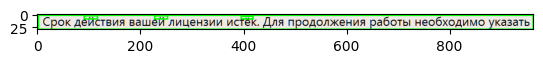

In [ ]:
# padding = 5
# x, y, w, h = cv2.boundingRect(sorted_contours[3])
# x, y, w, h = (x - padding, y - padding, w + padding, h + padding)
# line_image = orgImg[y:y + h, x:x -250]
# line_image = cv2.cvtColor(line_image, cv2.COLOR_BGR2GRAY)
# if np.average(line_image) < (255 * 0.5):
#     line_image = cv2.bitwise_not(line_image)


# tempImage = cv2.resize(line_image, (800, 64),
#                interpolation=cv2.INTER_AREA)
# tempImage = cv2.rotate(tempImage, cv2.ROTATE_90_CLOCKWISE)
# tempImage = cv2.GaussianBlur(tempImage, (3, 3), 0)
# tempImage = cv2.threshold(tempImage, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1].astype('bool')
# plt.imshow(cv2.rotate(
#       (tempImage).astype(np.uint8),cv2.ROTATE_90_COUNTERCLOCKWISE),
#       cmap='gray')

# tempImage = tempImage.reshape((1, 800, 64, 1))
# predicts = model.predict([tempImage])
# predicts_1 = decode_text(predicts)
# print(predicts_1)